In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

In [2]:
linear_train_df = pd.read_csv('combined_data/linear_train_data.csv')
linear_val_df = pd.read_csv('combined_data/linear_val_data.csv')
linear_test_df = pd.read_csv('combined_data/linear_test_data.csv')
non_linear_train_df = pd.read_csv('combined_data//non_linear_train_data.csv')
non_linear_val_df = pd.read_csv('combined_data//non_linear_val_data.csv')
non_linear_test_df = pd.read_csv('combined_data//non_linear_test_data.csv')
overlapping_train_df = pd.read_csv('combined_data/overlapping_train_data.csv')
overlapping_val_df = pd.read_csv('combined_data/overlapping_val_data.csv')
overlapping_test_df = pd.read_csv('combined_data/overlapping_test_data.csv')

In [3]:
class GaussianBayesClassifier:
    def __init__(self):
        self.class_priors = {}  # Prior probabilities for each class
        self.class_means = {}   # Mean vectors for each class
        self.class_covs = {}    # Covariance matrices for each class

    def fit(self, train_data, train_labels):
        unique_classes = np.unique(train_labels)
        
        for class_label in unique_classes:
            X_class = train_data[train_labels == class_label]
            
            self.class_priors[class_label] = len(X_class) / len(train_data)
            self.class_means[class_label] = np.mean(X_class, axis=0)
            
            # Calculate the covariance matrix for each class
            self.class_covs[class_label] = np.cov(X_class, rowvar=False)  

    def predict(self, X):
        predicted_labels = []
        
        for x in X:
            class_scores = {}
            
            for class_label in self.class_priors:
                # Calculate the likelihood of x given the class using multivariate Gaussian density
                likelihood = self.multivariate_gaussian(x, class_label)
                
                # Calculate the posterior probability using Bayes' rule
                posterior = self.class_priors[class_label] * likelihood
                
                class_scores[class_label] = posterior
            
            # Predict the class label with the highest posterior probability
            predicted_label = max(class_scores, key=class_scores.get)
            predicted_labels.append(predicted_label)

        return np.array(predicted_labels)
    
    def multivariate_gaussian(self, x, class_label):
        mean = self.class_means[class_label]
        cov = self.class_covs[class_label]
        x_minus_mean = x - mean
        cov_inv = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        exponent = -0.5 * np.dot(x_minus_mean, np.dot(cov_inv, x_minus_mean))
        coef = 1 / (np.sqrt((2 * np.pi) ** len(mean) * det_cov))
        return coef * np.exp(exponent)


In [4]:
def train_and_evaluate(train_df, val_df, test_df):
    train_data = train_df[['X', 'Y']].to_numpy()
    train_labels = train_df['Label'].to_numpy()

    val_data = val_df[['X', 'Y']].to_numpy()
    val_labels = val_df['Label'].to_numpy()

    test_data = test_df[['X', 'Y']].to_numpy()
    test_labels = test_df['Label'].to_numpy()


    clf = GaussianBayesClassifier()
    
    clf.fit(train_data, train_labels)

    val_predictions = clf.predict(val_data)
    test_predictions = clf.predict(test_data)

    # Calculate validation and test accuracies
    val_accuracy = accuracy_score(val_labels, val_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    return val_labels, test_predictions, val_accuracy, test_accuracy

In [5]:
linear_test_labels, linear_test_predictions, linear_val_accuracy, linear_test_accuracy = train_and_evaluate(
    linear_train_df,
    linear_val_df,
    linear_test_df
)

# Print the accuracy results
print("Linearly Separable Validation Data Accuracy:", linear_val_accuracy)
print("Linearly Separable Test Data Accuracy:", linear_test_accuracy)

Linearly Separable Validation Data Accuracy: 1.0
Linearly Separable Test Data Accuracy: 1.0


In [6]:
non_linear_test_labels, non_linear_test_predictions, non_linear_val_accuracy, non_linear_test_accuracy = train_and_evaluate(
    non_linear_train_df,
    non_linear_val_df,
    non_linear_test_df
)

# Print the accuracy results
print("Non Linearly Separable Validation Data Accuracy:", non_linear_val_accuracy)
print("Non Linearly Separable Test Data Accuracy:", non_linear_test_accuracy)

Non Linearly Separable Validation Data Accuracy: 0.9166666666666666
Non Linearly Separable Test Data Accuracy: 0.935


In [7]:
overlapping_test_labels,overlapping_test_predictions, overlapping_val_accuracy, overlapping_test_accuracy = train_and_evaluate(
    overlapping_train_df,
    overlapping_val_df,
    overlapping_test_df
)

# Print the accuracy results
print("Overlapping Separable Validation Data Accuracy:", overlapping_val_accuracy)
print("Overlapping Separable Test Data Accuracy:", overlapping_test_accuracy)

Overlapping Separable Validation Data Accuracy: 0.92
Overlapping Separable Test Data Accuracy: 0.8833333333333333


In [8]:
overlapping_test_labels = overlapping_test_df['Label'].to_numpy()
non_linear_test_labels = non_linear_test_df['Label'].to_numpy()
linear_test_labels = linear_test_df['Label'].to_numpy()

In [9]:
linear_confusion_matrix = confusion_matrix(linear_test_labels, linear_test_predictions)
non_linear_confusion_matrix = confusion_matrix(non_linear_test_labels, non_linear_test_predictions)
overlapping_confusion_matrix = confusion_matrix(overlapping_test_labels, overlapping_test_predictions)

In [10]:
linear_confusion_matrix_percentage = linear_confusion_matrix.astype('float') / linear_confusion_matrix.sum(axis=1)[:, np.newaxis] * 100
non_linear_confusion_matrix_percentage = non_linear_confusion_matrix.astype('float') / non_linear_confusion_matrix.sum(axis=1)[:, np.newaxis] * 100
overlapping_confusion_matrix_percentage = overlapping_confusion_matrix.astype('float') / overlapping_confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

In [11]:
def plot_heatmaps(heatmaps, titles, x_labels, y_labels, cmaps = ['Blues', 'Greens', 'Reds']):
    """
    Plot a list of heatmaps in a side-by-side layout.

    Args:
        heatmaps (list of 2D arrays): List of confusion matrices or heatmaps.
        titles (list of str): Titles for each heatmap.
        x_labels (list of str): X-axis labels for each heatmap.
        y_labels (list of str): Y-axis labels for each heatmap.
        cmaps (list of str): Colour maps for each heatmap.

    """
    num_heatmaps = len(heatmaps)
    num_rows = 1
    num_cols = num_heatmaps

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6))

    if num_heatmaps == 1:
        axes = [axes]

    # Loop through each heatmap and plot it
    for i in range(num_heatmaps):
        ax = axes[i]
        if(i == 1):
            x_, y_ = x_labels[:-1], y_labels[:-1]
        else:
            x_, y_ = x_labels, y_labels
            
        sns.heatmap(np.transpose(heatmaps[i])/100, annot=True, 
                    cmap=cmaps[i], fmt=".2%", 
                    annot_kws={"size": 16}, square=True,
                    xticklabels=x_, yticklabels=y_, ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Actual Labels')
        ax.set_ylabel('Predicted Labels')

    plt.tight_layout()
    plt.show()

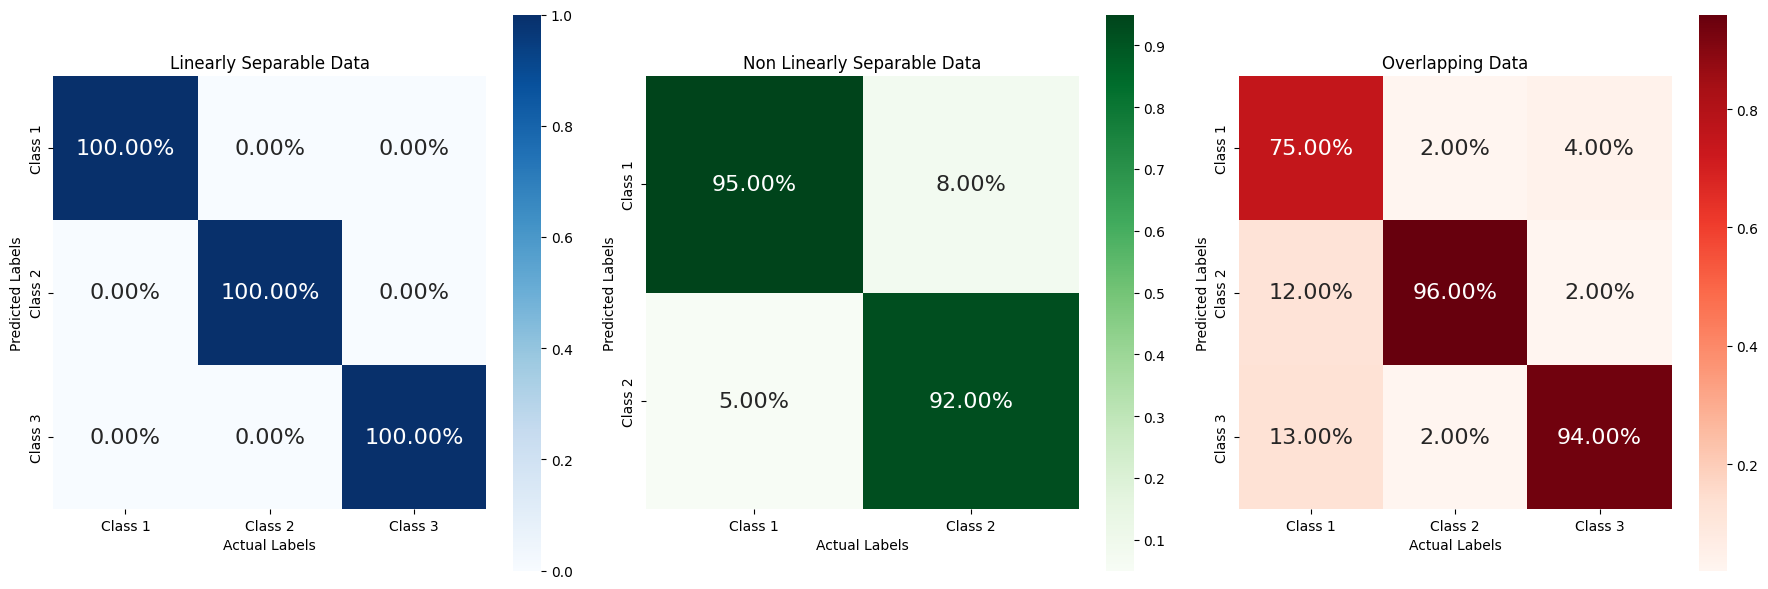

In [12]:
matrices = [linear_confusion_matrix_percentage , non_linear_confusion_matrix_percentage, overlapping_confusion_matrix_percentage]
titles = ['Linearly Separable Data', 'Non Linearly Separable Data', 'Overlapping Data']
x_labels = ['Class 1', 'Class 2', 'Class 3']
y_labels = ['Class 1', 'Class 2', 'Class 3']
cmaps = ['Blues', 'Greens', 'Reds']
plot_heatmaps(matrices, titles, x_labels, y_labels, cmaps)

In [13]:
def calculate_metrics_and_accuracy(test_labels, predicted_labels):
    """
    Calculate precision, recall, F1 score, and accuracy based on test and predicted labels.

    Parameters:
    - test_labels (array-like): True labels from the test data.
    - predicted_labels (array-like): Predicted labels from a classification model.

    Returns:
    - accuracy_df (pd.DataFrame): DataFrame containing the accuracy of the model on the test data.
    - metrics_df (pd.DataFrame): DataFrame containing precision, recall, and F1 score for each class and their mean.

    """
    
    num_classes = len(np.unique(test_labels))
    
    precision_per_class = precision_score(test_labels, predicted_labels, average=None)
    recall_per_class = recall_score(test_labels, predicted_labels, average=None)
    f1_score_per_class = f1_score(test_labels, predicted_labels, average=None)

    mean_precision = np.mean(precision_per_class)
    mean_recall = np.mean(recall_per_class)
    mean_f1_score = np.mean(f1_score_per_class)

    precision_per_class = np.round(np.append(precision_per_class, mean_precision), 2)
    recall_per_class = np.round(np.append(recall_per_class, mean_recall), 2)
    f1_score_per_class = np.round(np.append(f1_score_per_class, mean_f1_score), 2)

    metrics_df = pd.DataFrame({
        'Class': [f'Class {i + 1}' for i in range(num_classes)] + ['Mean'],
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1 Score': f1_score_per_class
    })

    test_accuracy = round(accuracy_score(test_labels, predicted_labels), 2)
    accuracy_df = pd.DataFrame({'Accuracy': [test_accuracy]})

    return accuracy_df, metrics_df

In [14]:
def plot_accuracy_and_metrics(test_labels, predicted_labels, data_type):
    """
    Plot accuracy and metrics tables side by side with a title.

    Parameters:
    - test_labels (array-like): True labels from the test data.
    - predicted_labels (array-like): Predicted labels from a classification model.
    - data_type (str): A string indicating the type of test data (e.g., 'Validation', 'Testing').

    """
    accuracy_df, metrics_df = calculate_metrics_and_accuracy(test_labels, predicted_labels)
    
    fig, ax = plt.subplots(figsize=(6, 2.5))

    data1 = [accuracy_df.columns.tolist()] + accuracy_df.values.tolist()
    data2 = [metrics_df.columns.tolist()] + metrics_df.values.tolist()

    table1 = ax.table(cellText=data1, loc='upper center', cellLoc='center')
    table1.auto_set_font_size(False)
    table1.set_fontsize(12)
    table1.scale(0.25, 1.25)  # Adjust the table size

    table2 = ax.table(cellText=data2, loc='lower center', cellLoc='center')
    table2.auto_set_font_size(False)
    table2.set_fontsize(12)
    table2.scale(1, 1.5)  # Adjust the table size

    ax.axis('off')

    plt.subplots_adjust(top=1.0, bottom=0.1)
    plt.title(f'Bayes Classifier Performance on {data_type} Test Data')
    plt.show()


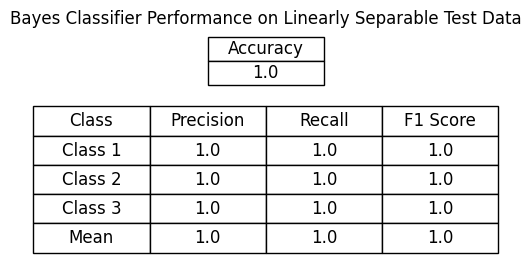

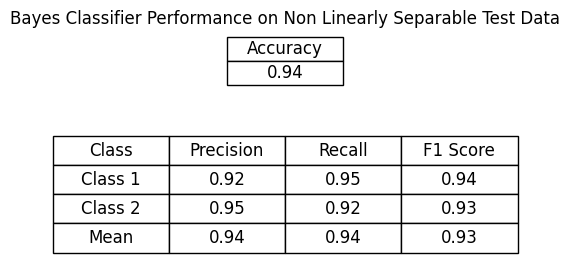

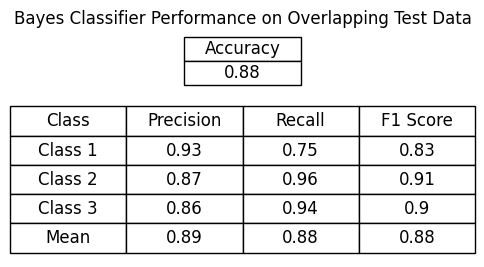

In [15]:
plot_accuracy_and_metrics(linear_test_labels, linear_test_predictions, 'Linearly Separable')
plot_accuracy_and_metrics(non_linear_test_labels, non_linear_test_predictions, 'Non Linearly Separable')
plot_accuracy_and_metrics(overlapping_test_labels,overlapping_test_predictions, 'Overlapping')

In [16]:
def decision_region_plot(train_df, clf, data_type):
    # Define color pairs
    color_pairs = [('#FF5733', '#33FF57'), ('#FF5733', '#3344FF'), ('#33FF57', '#3344FF')]

    # Create colormaps
    colormaps = []
    for color1, color2 in color_pairs:
        cmap_name = f'custom_{color1}_{color2}'
        cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, [color1, color2], N=256)
        colormaps.append(cmap)

    x_min, x_max = train_df['X'].min() - 1, train_df['X'].max() + 1
    y_min, y_max = train_df['Y'].min() - 1, train_df['Y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    class_mapping = {label: i + 1 for i, label in enumerate(train_df['Label'].unique())}

    class_pairs = []
    num_classes = len(class_mapping)
    
    if num_classes == 2:
        class_pairs.append((list(class_mapping.keys())[0], list(class_mapping.keys())[1]))
    else:
        class_pairs = [(class1, class2) for class1 in train_df['Label'].unique() for class2 in train_df['Label'].unique() if class1 < class2]

    num_plots = len(class_pairs)

    plt.figure(figsize=(15, 8))
    plt.suptitle(f"Decision Region plot for every pair of classes of {data_type} Data")
    
    for i, (class1, class2) in enumerate(class_pairs, 1):
        plt.subplot(1, num_plots, i)

        df_pair = train_df[(train_df['Label'] == class1) | (train_df['Label'] == class2)]

        X_pair = df_pair[['X', 'Y']].values
        y_pair = df_pair['Label'].values

        clf.fit(X_pair, y_pair)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        Z = np.vectorize(class_mapping.get)(Z)

        # Plot the decision boundary using the specified colormap
        plt.contourf(xx, yy, Z, cmap=colormaps[i-1], alpha=0.8)

        # Plot the decision boundary contour lines
        plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

        # Plot the training data points
        plt.scatter(X_pair[:, 0], X_pair[:, 1], c=[1 if label == class1 else 2 for label in y_pair],
                    cmap=colormaps[i-1], edgecolor='k', s=20)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'{class1} vs. {class2}')

    plt.tight_layout()
    plt.show()


KeyboardInterrupt: 

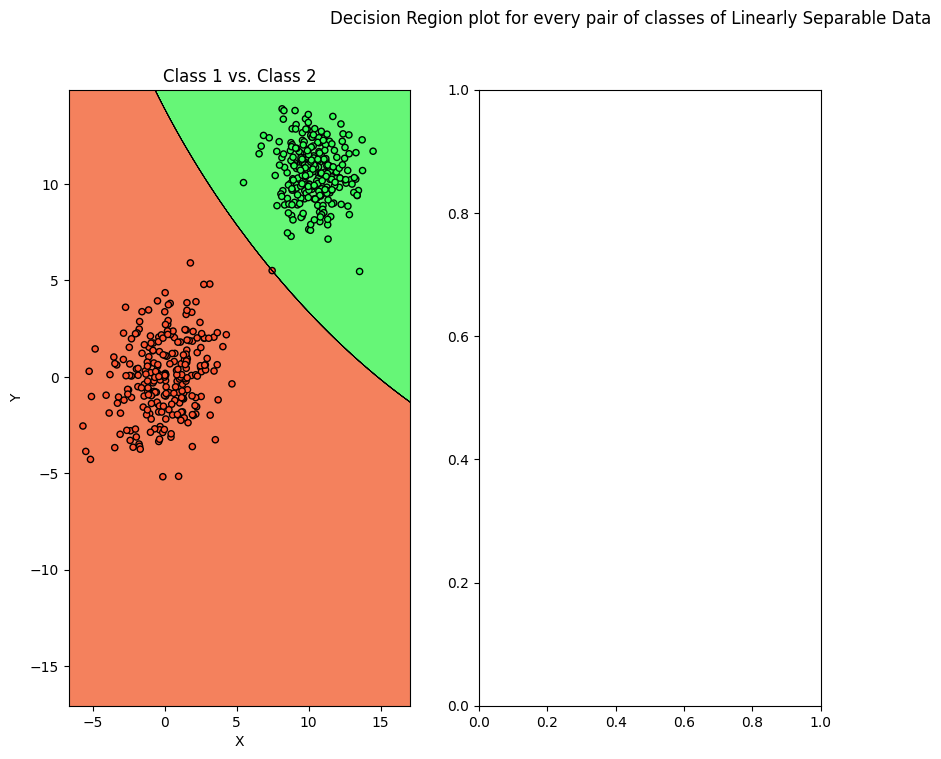

In [17]:
decision_region_plot(linear_train_df, GaussianBayesClassifier(), 'Linearly Separable')
decision_region_plot(non_linear_train_df, GaussianBayesClassifier(), 'Non Linearly Separable')
decision_region_plot(overlapping_train_df, GaussianBayesClassifier(), 'Overlapping')

In [ ]:
def decision_region_plot_all_classes(train_df, clf, data_type):
    # Define custom colormap with the three specified colors
    custom_colors = ['#FF5733', '#33FF57', '#3344FF']
    cmap = ListedColormap(custom_colors)

    x_min, x_max = train_df['X'].min() - 1, train_df['X'].max() + 1
    y_min, y_max = train_df['Y'].min() - 1, train_df['Y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    class_mapping = {label: i + 1 for i, label in enumerate(train_df['Label'].unique())}

    num_classes = len(class_mapping)

    plt.figure(figsize=(10, 6))
    plt.suptitle(f"Decision Region plot for all classes of {data_type} Data")

    X_all = train_df[['X', 'Y']].values
    y_all = train_df['Label'].values

    clf.fit(X_all, y_all)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = np.vectorize(class_mapping.get)(Z)

    # Plot the decision boundary using the custom colormap
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.8)

    # Plot the decision boundary contour lines
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

    # Plot the training data points
    scatter = plt.scatter(X_all[:, 0], X_all[:, 1], 
                          c=[1 if label == 'Class 1' else (2 if label == 'Class 2' else 3) for label in y_all], 
                          cmap=cmap, edgecolor='k', s=20)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(*scatter.legend_elements(), title='Classes', loc='best')

    plt.tight_layout()
    plt.show()


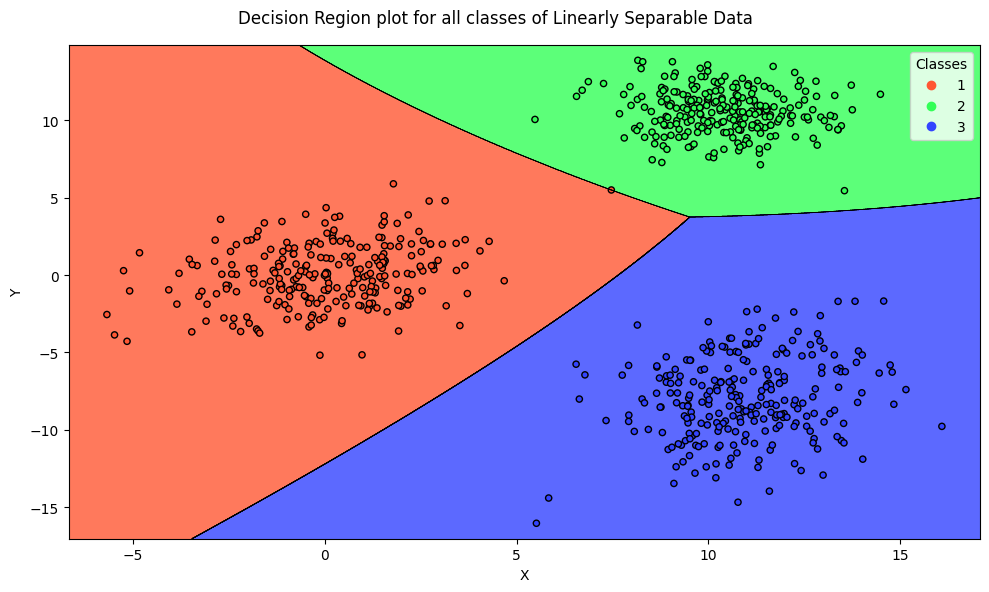

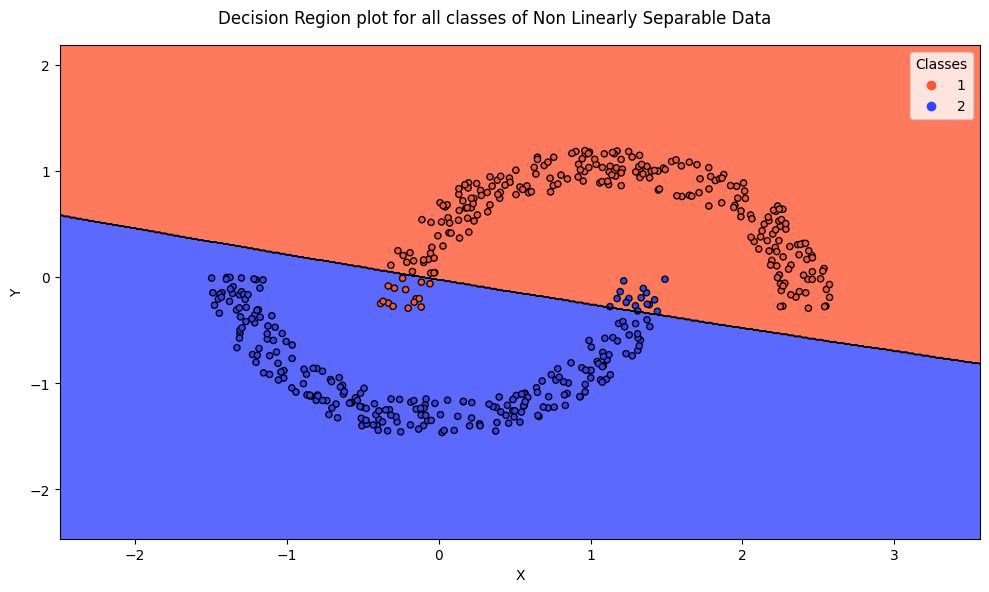

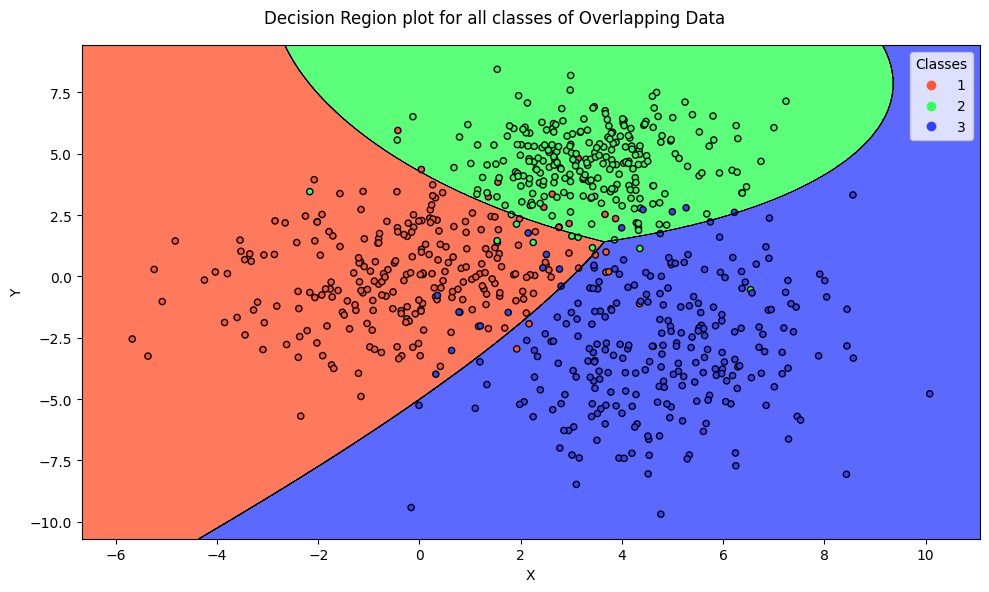

In [ ]:
decision_region_plot_all_classes(linear_train_df, GaussianBayesClassifier(), 'Linearly Separable')
decision_region_plot_all_classes(non_linear_train_df, GaussianBayesClassifier(), 'Non Linearly Separable')
decision_region_plot_all_classes(overlapping_train_df, GaussianBayesClassifier(), 'Overlapping')

In [ ]:
def decision_region_plot_test_points(train_df, test_df, clf, data_type):
    
    colormap = mcolors.ListedColormap(['#FF5733', '#33FF57', '#3344FF'])

    x_min, x_max = min(train_df['X'].min(), test_df['X'].min()) - 1, max(train_df['X'].max(), test_df['X'].max()) + 1
    y_min, y_max = min(train_df['Y'].min(), test_df['Y'].min()) - 1, max(train_df['Y'].max(), test_df['Y'].max()) + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    class_mapping = {label: i for i, label in enumerate(train_df['Label'].unique())}

    num_classes = len(class_mapping)

    plt.figure(figsize=(10, 6))
    plt.title(f"Decision Region plot for all classes of {data_type} Test Data")

    df_train = train_df.copy()
    df_test = test_df.copy()

    X_train = df_train[['X', 'Y']].values
    y_train = df_train['Label'].values
    
    # y_train = df_train['Label'].map(class_mapping).values

    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = np.vectorize(class_mapping.get)(Z)


    # Plot the decision regions using the specified colormap
    plt.contourf(xx, yy, Z, cmap=colormap, alpha=0.8, levels=np.arange(num_classes + 1) - 0.5)

    # Plot the decision boundary contour lines
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

    # Plot the testing data points
    X_test = df_test[['X', 'Y']].values
    y_test = df_test['Label'].values
    scatter = plt.scatter(X_test[:, 0], X_test[:, 1], 
                          c=[1 if label == 'Class 1' else (2 if label == 'Class 2' else 3) for label in y_test],
                          cmap=colormap, edgecolor='k', s=30, label='Testing Data')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(*scatter.legend_elements(), title='Classes', loc='best')
    
    plt.tight_layout()
    plt.show();

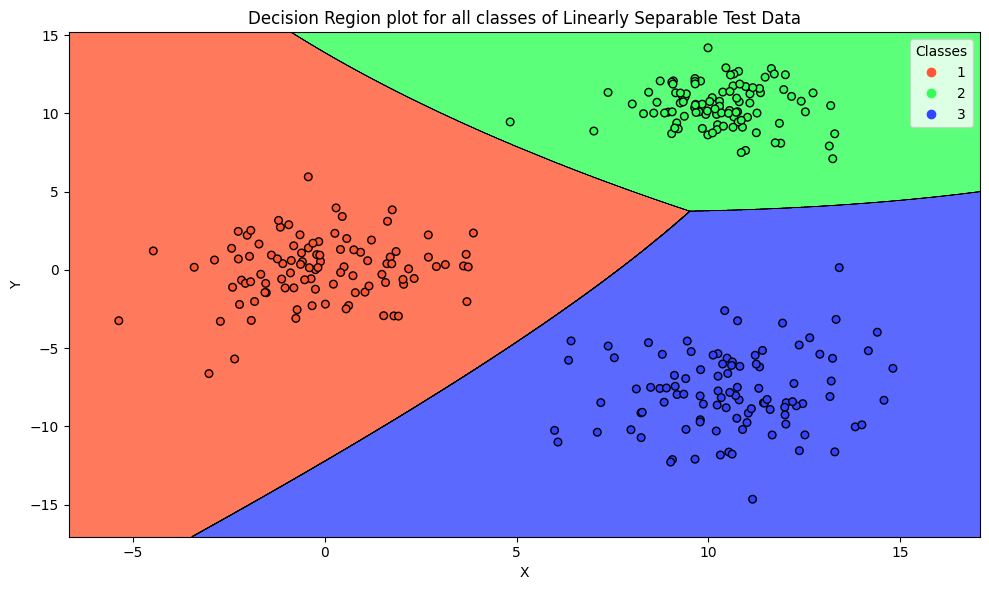

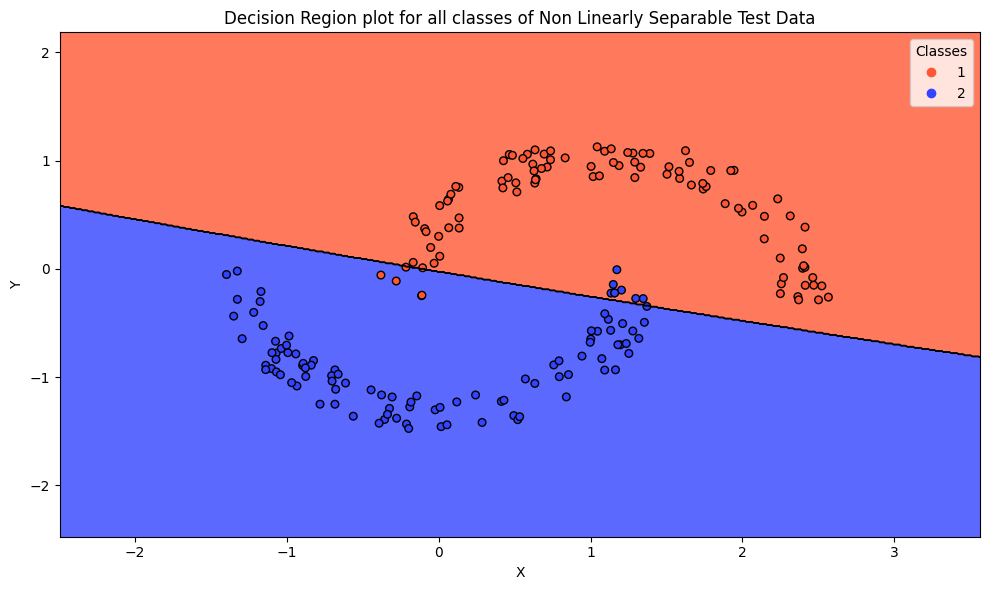

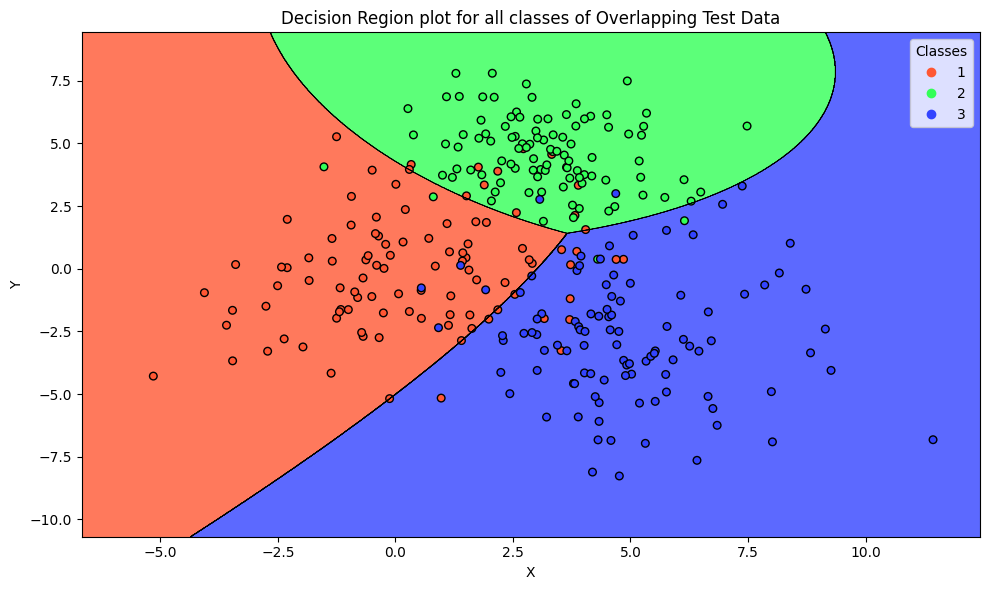

In [ ]:
decision_region_plot_test_points(linear_train_df, linear_test_df, GaussianBayesClassifier(), 'Linearly Separable')
decision_region_plot_test_points(non_linear_train_df, non_linear_test_df,GaussianBayesClassifier(), 'Non Linearly Separable')
decision_region_plot_test_points(overlapping_train_df, overlapping_test_df, GaussianBayesClassifier(), 'Overlapping')